In [2]:
import cv2
import numpy as np
import os
import torch
import torch.nn.functional as F
from torchvision.transforms import Compose
from tqdm import tqdm

from depth_anything.dpt import DepthAnything
from depth_anything.util.transform import Resize, NormalizeImage, PrepareForNet

import matplotlib.pyplot as plt

In [3]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

In [4]:
depth_anything = DepthAnything.from_pretrained('LiheYoung/depth_anything_{}14'.format('vitb')).to(DEVICE).eval()
    
total_params = sum(param.numel() for param in depth_anything.parameters())
print('Total parameters: {:.2f}M'.format(total_params / 1e6))
    
transform = Compose([
    Resize(
        width=518,
        height=518,
        resize_target=False,
        keep_aspect_ratio=True,
        ensure_multiple_of=14,
        resize_method='lower_bound',
        image_interpolation_method=cv2.INTER_CUBIC,
    ),
    NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    PrepareForNet(),
])

xFormers not available
xFormers not available


Total parameters: 97.47M


In [5]:
def get_depth(img: np.ndarray) -> np.ndarray:
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0

    h, w = image.shape[:2]
    
    image = transform({'image': image})['image']
    image = torch.from_numpy(image).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        depth = depth_anything(image)

    depth = F.interpolate(depth[None], (h, w), mode='bilinear', align_corners=False)[0, 0]
    depth = (depth - depth.min()) / (depth.max() - depth.min()) * 255.0
        
    depth = depth.cpu().numpy().astype(np.uint8)

    #return depth
    return np.repeat(depth[..., np.newaxis], 3, axis=-1)

In [6]:
img_pose_file = "/home/jason/ROS/bags/analysis/pose.txt"
img_pose = list()

f = open(img_pose_file, "r")
content = f.readlines()

In [7]:
frame1 = content[75].split(',')
frame2 = content[76].split(',')

frame1_pose = (float(frame1[1]), float(frame1[2]), float(frame1[3]))
frame1_img = frame1[0]

frame2_pose = (float(frame2[1]), float(frame2[2]), float(frame2[3]))
frame2_img = frame2[0]

In [8]:
img1 = cv2.imread("/home/jason/ROS/bags/images/wp_ground/"+frame1_img)
img2 = cv2.imread("/home/jason/ROS/bags/images/wp_ground/"+frame2_img)

pose_change = (frame1_pose[0]-frame2_pose[0],
               frame1_pose[1]-frame2_pose[1],
               frame1_pose[2]-frame2_pose[2])
pose_change

(0.10934988782966126, 0.2349110031676913, 0.014778104339624676)

In [9]:
depth1 = get_depth(img1)
depth2 = get_depth(img2)

<Figure size 640x480 with 0 Axes>

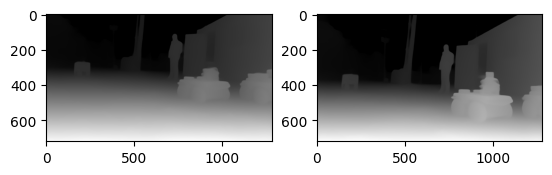

In [10]:
plt.figure()

f, ax = plt.subplots(1,2)

ax[0].imshow(depth1)
ax[1].imshow(depth2)

In [11]:
fov_deg = 42 
fov_rad = 42* (np.pi/180)
height = 0.36

In [19]:
s = 180 - (90 - (fov_deg/2) + 90) 
l = height / np.tan(s*(np.pi/180))

l

0.9378320632897685

In [21]:
print(depth1.shape)

(720, 1280, 3)


(720, 1280)


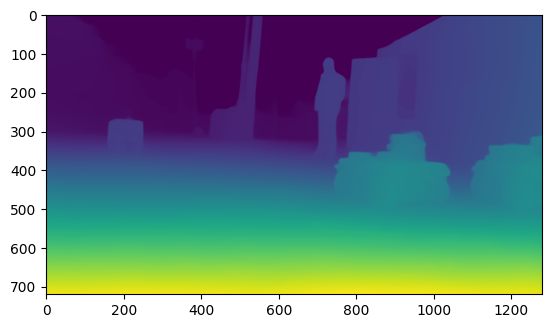

In [25]:
depth1_gs = depth1[:,:,0]
print(depth1_gs.shape)
plt.imshow(depth1_gs)

In [35]:
print("Min: ", np.min(depth1_gs), " Max: ", np.max(depth1_gs))

Min:  0  Max:  255


## Notes
- $255 \rightarrow l$ and $0 \rightarrow \infty$
- What does one change in pixel value $255 \rightarrow 254$ equate to in change in meters? What is the scale?  